# Time Series

In [27]:
# Clears all user-defined variables, functions, and imports without asking for confirmation.
%reset -f

In [28]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from pyts.metrics import dtw as pyts_dtw 
import warnings
warnings.simplefilter("ignore", FutureWarning) # pyts.metrics.dtw returns a FutureWarning
# from scipy.interpolate import interp1d
# from dtaidistance import dtw
# from scipy.stats import pearsonr

# 3 Preliminaries and Problem Statement

## 3.1 Euclidean Distance (ED)

Self-implemented ED

In [29]:
def ed(ts1, ts2, squared = False):
    ts1 = np.array(ts1)
    ts2 = np.array(ts2)
    dist = np.sum((ts1 - ts2)**2)
    if not squared:
        return np.sqrt(dist)
    else:
        return dist

In [30]:
# Data from https://jmotif.github.io/sax-vsm_site/morea/algorithm/znorm.html
q = pd.Series(np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34]))
c = pd.Series(np.array([-0.12, -0.16, -0.13,  0.28,  0.37,  0.39,  0.18,  0.09,  0.15, -0.06,  0.06, -0.07, -0.13, -0.18, -0.26]))

In [31]:
ed(q, c), ed(q, c, True)

(np.float64(19.942780648645765), np.float64(397.7145))

In [32]:
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.squared_distance.html
from sktime.distances import euclidean_distance as sktime_ed, squared_distance as sktime_ed_sq
sktime_ed(q.to_numpy(), c.to_numpy()), sktime_ed_sq(q.to_numpy(), c.to_numpy())


(19.942780648645765, 397.7145)

## 3.3 Uniform Scaling (US)

## Interpolation

In [33]:
# from scipy.ndimage import zoom
# def nearest_neighbor_interpolation(ts, new_length):
#     # order = 0 for nearest neighbor interpolation
#     return zoom(ts, new_length/len(ts), order=0)


In [34]:
# def nearest_neighbor_interpolation2(ts, new_length):
#     old_length = len(ts)
#     indices = np.ceil(np.linspace(1, old_length, new_length)).astype(int) - 1  # -1 for 0-based indexing
#     return np.array(ts)[indices]

In [35]:
def nearest_neighbor_interpolation(ts, L):
    ts = np.asarray(ts)
    k = len(ts)
    indices = [int(np.ceil(j * k / L)) - 1 for j in range(1, L + 1)]  # Why -1? 1-based (in the paper) to 0-based (default in Python)
    return ts[indices]

In [36]:
# https://stackoverflow.com/questions/66934748/how-to-stretch-an-array-to-a-new-length-while-keeping-same-value-distribution
def linear_interpolation(array: np.ndarray, new_len: int) -> np.ndarray:
    la = len(array)
    return np.interp(np.linspace(0, la - 1, num=new_len), np.arange(la), array)

In [37]:
ts = np.array([1,2,3,4,5,6])
nearest_neighbor_interpolation(ts, 8)

array([1, 2, 3, 3, 4, 5, 6, 6])

In [38]:
def normalize(ts):
    mean = np.mean(ts)
    std = np.std(ts)
    return (ts - mean) / std

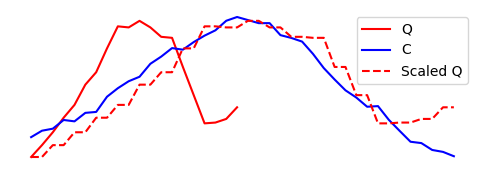

In [39]:
np.random.seed(0)
q = np.cumsum(np.random.rand(20) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 20)))
c = np.cumsum(np.random.rand(40) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 40)))
# c_x2 = np.linspace(0, 1, 10)
# c_y2 = np.piecewise(c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
# c_y2 = c_y2 *5
# offset = c[-1] - c_y2[0]
# c_y2 = c_y2 + offset
# c = np.concatenate([c, c_y2])
q_scaled = nearest_neighbor_interpolation(q, len(c))

q = normalize(q)
c = normalize(c)
q_scaled = normalize(q_scaled)

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(6, 2))

ax1.plot(q, label='Q', color='red')
ax1.plot(c, label='C', color='blue')
ax1.plot(q_scaled, label='Scaled Q', linestyle='--', color='red')

# ax1.set_title('Example of US')
ax1.legend()

# https://stackoverflow.com/questions/9295026/how-to-remove-axis-legends-and-white-padding
plt.axis('off')
# https://www.tutorialspoint.com/save-the-plots-into-a-pdf-in-matplotlib
plt.savefig("../figures/us.pdf", format="pdf", bbox_inches="tight")
plt.show()


Another example

In [40]:
c_x1 = np.linspace(0, 4 * np.pi, 100)
c_y1 = np.sin(c_x1) * 50 + 50  # Scale to range around 0~100
c_x2 = np.linspace(0, 1, 20)
c_y2 = np.piecewise(c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
c_y2 = c_y2 * 50  # Scale it similarly
offset = c_y1[-1] - c_y2[0]
c_y2 = c_y2 + offset
c = np.concatenate([c_y1, c_y2])
q_x = np.linspace(0, 4 * np.pi, 70)
q = np.sin(q_x) * 50 + 50  # Scale to range around 0~100
m = len(q)
n = len(c)
print(m, n)


70 120


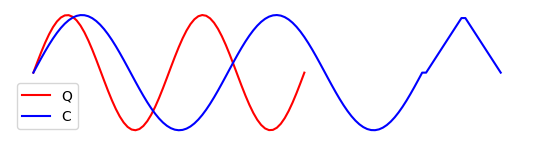

In [41]:
fig, ax1 = plt.subplots(figsize=(6, 2))
plt.plot(q, color='red', label='Q')
plt.plot(c, color='blue', label='C')
# plt.title('C vs. Q')
plt.xlabel('Time steps')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.axis('off')
plt.savefig("../figures/us-prefix.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [42]:
c_prefix = c[:100]
c_prefix_scaled = nearest_neighbor_interpolation(c_prefix, len(q))

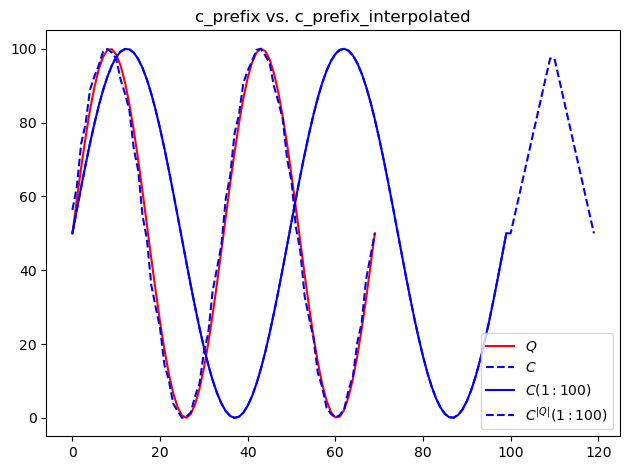

In [43]:
plt.plot(q, color='red', label='$Q$')
plt.plot(c, color='blue', linestyle='--', label='$C$')
plt.plot(c_prefix, color='blue', label='$C(1:100)$')
plt.plot(c_prefix_scaled, linestyle='--', color='blue', label='$C^{|Q|}(1:100)$')
plt.title('c_prefix vs. c_prefix_interpolated')
plt.legend()
plt.tight_layout()
plt.show()


Simply performing dtw on Q and C returns a bad result.

As shown in the above graph, Q and scaled C(1:100) have a good match.

In [44]:
ed(q, c_prefix_scaled)

np.float64(27.047409139811432)

In [45]:
def _us_usdtw_p(Q, C, l, distance_method="ed", r=0.1):
    # Scaling both time series
    m = len(Q)
    n = len(C)
    L = min(np.ceil(l * m), n)

    Q_scaled = nearest_neighbor_interpolation(Q, L)
    C_scaled = nearest_neighbor_interpolation(C, L)

    # Compute distance based on the chosen method
    if distance_method == 'dtw':
        dist = pyts_dtw(Q_scaled, C_scaled, method='sakoechiba', options={'window_size': r})
    elif distance_method == 'ed':
        dist = ed(Q_scaled, C_scaled)
    else:
        raise ValueError(f"Unsupported distance method: {distance_method}")

    return dist

In [46]:

def us_usdtw(Q, C, l, distance_method='ed', r=0.1):
    best_so_far = np.inf
    for k in range(math.ceil(m/l), min(math.ceil(l*m), n)+1):
        C_prefix = C[:k]
        dist = _us_usdtw_p(Q, C_prefix, l, distance_method, r)
        if dist < best_so_far:
            best_so_far = dist
            best_k = k
    return best_so_far, best_k


In [47]:
l = 2 # scaling_factor 
best_so_far, best_k = us_usdtw(q, c, l, "ed")

In [48]:
best_so_far, best_k, best_k/m*100 # best_k/m*100 is the best scaling factor

(np.float64(20.03655846980296), 101, 144.28571428571428)

In [49]:
best_so_far, best_k, best_k/m*100 # best_k/m*100 is the best scaling factor

(np.float64(20.03655846980296), 101, 144.28571428571428)

## 3.5 Lower Bounds for Distance Measures

In [50]:
# Sample sequences
np.random.seed(18)
q = np.sin(np.linspace(0, 4 * np.pi, 100))
c = q + np.random.normal(0, 0.4, size=100)

In [51]:
def lb_shen_argmin_q(q, c, r):
    m = len(q)
    n = len(c)
    dist = lambda a, b: (a - b)**2

    # total = dist(q[0], c[0]) + dist(q[-1], c[-1])
    window_contrib = []
    # window_contrib.append((0, 0)) 
    window_contrib.append(q[0]) 
    

    for j in range(1, n - 1):
        start = max(0, j - r)
        end = min(m, j + r + 1)
        q_window = q[start:end]
        argmin = np.argmin([dist(c[j], qk) for qk in q_window]) #qk = q_argmin
        # window_contrib.append((j, q_window[argmin]))
        window_contrib.append(q_window[argmin])
        # total += min_dist
    window_contrib.append(q[-1]) 
    return window_contrib

100
100


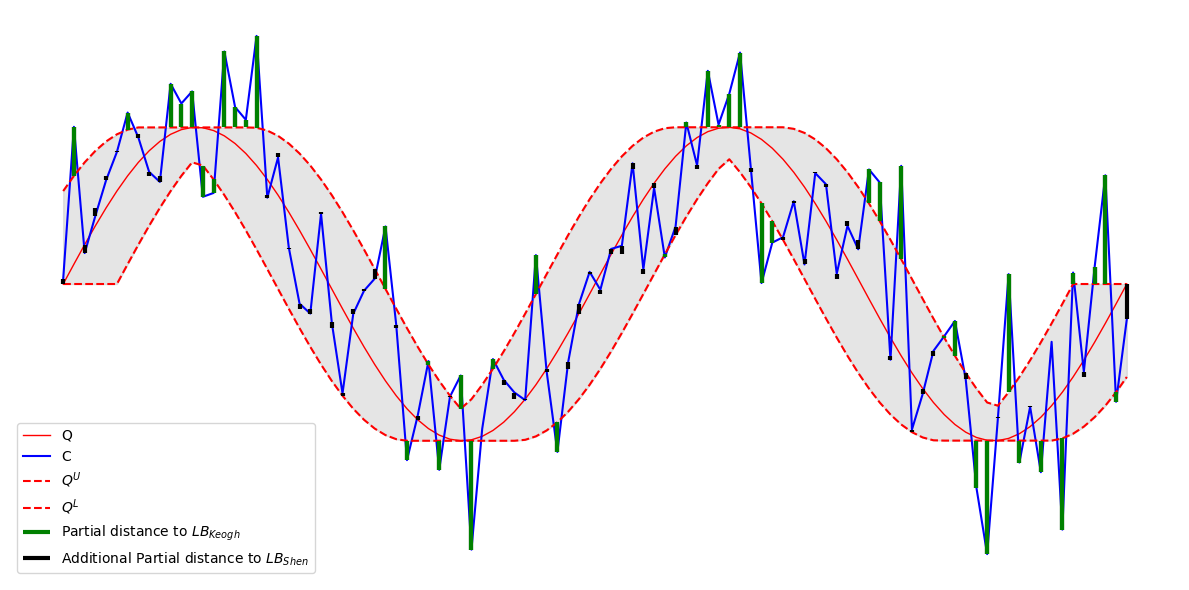

In [52]:

def lb_keogh_envelope(ts, radius):
    n = len(ts)
    upper = np.zeros(n)
    lower = np.zeros(n)
    for i in range(n):
        start = max(0, i - radius)
        end = min(n, i + radius + 1)
        lower[i] = np.min(ts[start:end])
        upper[i] = np.max(ts[start:end])
    return lower, upper

def lb_keogh(ts_query, ts_candidate, radius):
    lower, upper = lb_keogh_envelope(ts_query, radius)
    lb_sum = 0
    for i in range(len(ts_candidate)):
        if ts_candidate[i] > upper[i]:
            lb_sum += (ts_candidate[i] - upper[i])**2
        elif ts_candidate[i] < lower[i]:
            lb_sum += (ts_candidate[i] - lower[i])**2
    return np.sqrt(lb_sum)


def plot_lb_keogh_full(q, c, radius):
    x = np.arange(len(q))
    lower, upper = lb_keogh_envelope(q, radius)
    lb = lb_keogh(q, c, radius)

    plt.figure(figsize=(12, 6))

    # Plot Q and C
    plt.plot(x, q, label='Q', color='red', linewidth=1)
    plt.plot(x, c, label='C', color='blue', linewidth=1.5)
    # Plot envelope
    plt.plot(x, upper, label='$Q^U$', linestyle='--', color='red', linewidth=1.5)
    plt.plot(x, lower, label='$Q^L$', linestyle='--', color='red', linewidth=1.5)
    plt.fill_between(x, lower, upper, color='gray', alpha=0.2)
    # Vertical bars
    # Old version
    # for i in x:
    #     if c[i] > upper[i]:
    #         plt.vlines(i, upper[i], c[i], color='black', linewidth=1.5)
    #     elif c[i] < lower[i]:
    #         plt.vlines(i, lower[i], c[i], color='black', linewidth=1.5)

    print(len(lower))
    first_pair_smallest_elts_last_pair = lb_shen_argmin_q(q, c, r=5)
    print(len(np.array(first_pair_smallest_elts_last_pair)))
    plt.vlines(np.arange(len(q)), c, first_pair_smallest_elts_last_pair,
           label='Additional Partial distance to $LB_{Shen}$', color='black', linewidth=3.0)
    # Elegant version
    plt.vlines(np.arange(len(q)), c, np.clip(c, lower, upper),
           label='Partial distance to $LB_{Keogh}$', color='green', linewidth=3.0)

    # plt.title(f"LB_Keogh Visualization\nLower Bound = {lb:.4f}")
    # plt.xlabel("Time Index")
    # plt.ylabel("Value")

    # Get all legend handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    # Swap the last two (assuming they are in the expected order)
    handles[-2], handles[-1] = handles[-1], handles[-2]
    labels[-2], labels[-1] = labels[-1], labels[-2]

    plt.legend(handles=handles, labels=labels, loc='lower left')
    # plt.legend(loc='upper right')
    # plt.grid(True)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("../figures/lb_keogh-lb_shen.pdf", format="pdf", bbox_inches="tight")
    plt.show()



plot_lb_keogh_full(q, c, radius=5)


# 4 Piecewise Scaling & Dynamic Time Warping (PD)

# 5 Lower Bound of PD

# 6 Experimental Evaluation

# ---

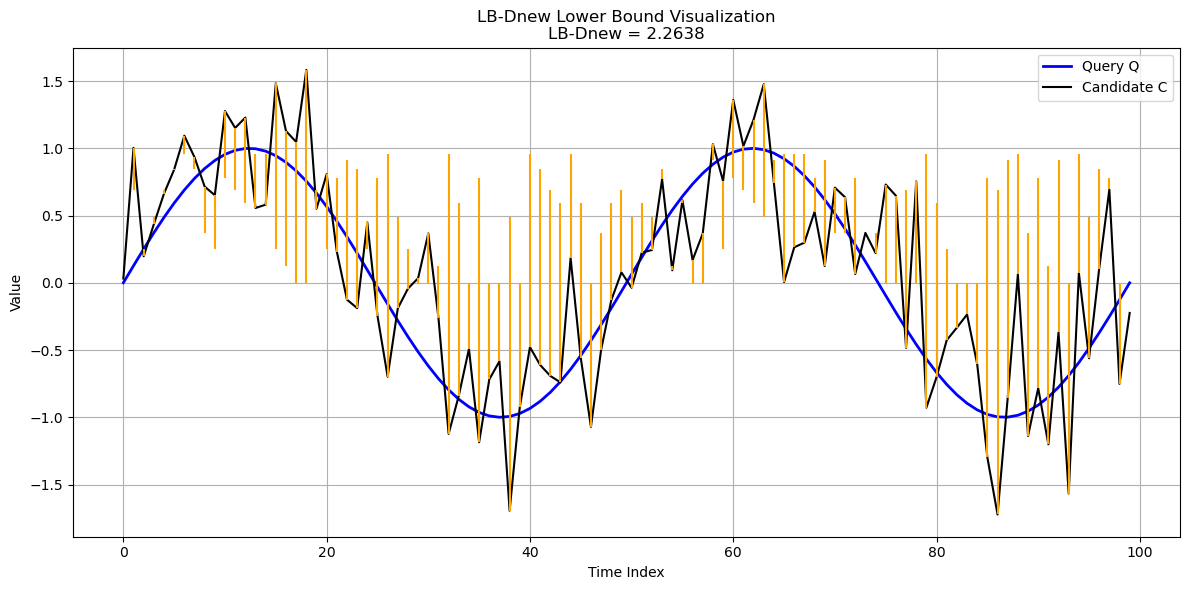

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def lb_dnew(q, c, r):
    n = len(c)
    m = len(q)
    dist = lambda a, b: (a - b)**2

    total = dist(q[0], c[0]) + dist(q[-1], c[-1])
    window_contrib = []

    for j in range(1, n - 1):
        start = max(0, j - r)
        end = min(m, j + r + 1)
        local_window = q[start:end]
        min_dist = np.min([dist(c[j], qk) for qk in local_window])
        window_contrib.append((j, min_dist))
        total += min_dist

    return total, window_contrib

def plot_lb_dnew(q, c, r):
    lb, contribs = lb_dnew(q, c, r)
    x = np.arange(len(c))

    plt.figure(figsize=(12, 6))
    plt.plot(q, label="Query Q", color="blue", linewidth=2)
    plt.plot(c, label="Candidate C", color="black", linewidth=1.5)

    # Red vertical bars showing min distance from c[j] to q[j±r]
    for j, min_d in contribs:
        if min_d > 0:
            closest_q_val = q[np.argmin([abs(c[j] - qk) for qk in q[max(0, j - r):min(len(q), j + r + 1)]])]
            plt.vlines(j, c[j], closest_q_val, color='orange', linewidth=1.5)

    plt.title(f"LB-Dnew Lower Bound Visualization\nLB-Dnew = {np.sqrt(lb):.4f}")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example sequences
np.random.seed(18)
q = np.sin(np.linspace(0, 4 * np.pi, 100))
c = q + np.random.normal(0, 0.4, size=100)

plot_lb_dnew(q, c, r=5)


In [54]:
q = np.array([1,1,1,2,2,2])
c = np.array([1,1,1,1,2,2,2,2,5,6,7])

# tslearn

In [55]:
from tslearn import metrics
ts1 = [1, 2, 3, 2, 1]
ts2 = [0, 0, 0, 0, 0]
env_low, env_up = metrics.lb_envelope(ts1, radius=1)

/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [56]:
metrics.lb_keogh(ts_query=ts2, envelope_candidate=(env_low, env_up))

np.float64(2.8284271247461903)

# Testing

In [57]:
def nearest_neighbor_interpolation(ts, L):
    ts = np.asarray(ts)
    k = len(ts)
    indices = [int(np.ceil(j * k / L)) - 1 for j in range(1, L + 1)]  # Why -1? 1-based (in the paper) to 0-based (default in Python)
    return ts[indices]

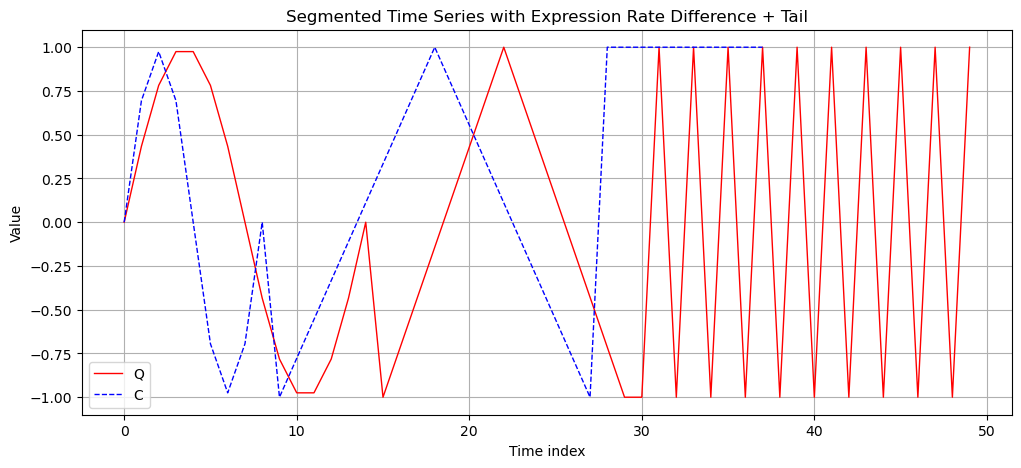

(50, 38)

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sawtooth

# Step 1: Create segments
def generate_segments():
    s1 = np.sin(np.linspace(0, 2 * np.pi, 15)) 
    # s1 = np.linspace(0, 1, 15)
    s2 = sawtooth(np.linspace(0, 2 * np.pi, 15), 0.5)  # Triangle wave (periodic)
    # s2 = np.concatenate([np.ones(10), np.linspace(1, 0.5, 5)])
    s3 = np.tile([-1, 1], 10)
    tail = np.linspace(1, 0, 30)
    return s1, s2, s3, tail
    # return s1, s2, tail

# Step 3: Compose sequences
def create_series(with_tail=False):
    s1, s2, s3, tail = generate_segments()
    # s1, s2, tail = generate_segments()
    Q = np.concatenate([s1, s2, s3])
    # Q = np.concatenate([s1, s2])
    C = np.concatenate([
        linear_interpolation(s1, int(len(s1)*0.6)),
        linear_interpolation(s2, int(len(s2)*1.3)),
        nearest_neighbor_interpolation(s3, int(len(s3)*0.5))
    ])
    if with_tail:
        C = np.concatenate([C, tail])
    return Q, C

Q, C = create_series(False)

# Step 4: Plotting with ground truth segment boundaries
def plot_segmented_series(Q, C):
    plt.figure(figsize=(12, 5))
    plt.plot(Q, label="Q", color='red', linewidth=1)
    plt.plot(C, label="C", color='blue', linestyle='--', linewidth=1)

    # for idx in q_segments[1:-1]:  # skip 0 and end
    #     plt.axvline(idx, color='blue', linestyle='--', alpha=0.5)
    # for idx in c_segments[1:-1]:
    #     plt.axvline(idx, color='red', linestyle=':', alpha=0.5)

    plt.title("Segmented Time Series with Expression Rate Difference + Tail")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.show()

# # Step 5: Ground truth (simulated for this synthetic case)
# q_segments = [0, 30, 60, 90]  # Original segments in Q
# c_segments = [0,
#               len(scale_segment(np.linspace(0, 1, 30), 0.7)),
#               len(scale_segment(np.linspace(0, 1, 30), 0.7)) +
#               len(scale_segment(np.ones(30), 1.3)),
#               len(C)]  # including tail

plot_segmented_series(Q, C)
len(Q), len(C)


In [59]:
Q[:100]

array([ 0.00000000e+00,  4.33883739e-01,  7.81831482e-01,  9.74927912e-01,
        9.74927912e-01,  7.81831482e-01,  4.33883739e-01,  1.22464680e-16,
       -4.33883739e-01, -7.81831482e-01, -9.74927912e-01, -9.74927912e-01,
       -7.81831482e-01, -4.33883739e-01, -2.44929360e-16, -1.00000000e+00,
       -7.14285714e-01, -4.28571429e-01, -1.42857143e-01,  1.42857143e-01,
        4.28571429e-01,  7.14285714e-01,  1.00000000e+00,  7.14285714e-01,
        4.28571429e-01,  1.42857143e-01, -1.42857143e-01, -4.28571429e-01,
       -7.14285714e-01, -1.00000000e+00, -1.00000000e+00,  1.00000000e+00,
       -1.00000000e+00,  1.00000000e+00, -1.00000000e+00,  1.00000000e+00,
       -1.00000000e+00,  1.00000000e+00, -1.00000000e+00,  1.00000000e+00,
       -1.00000000e+00,  1.00000000e+00, -1.00000000e+00,  1.00000000e+00,
       -1.00000000e+00,  1.00000000e+00, -1.00000000e+00,  1.00000000e+00,
       -1.00000000e+00,  1.00000000e+00])

In [60]:
C[:22], C[22:]

(array([ 0.00000000e+00,  3.57316020e-01,  6.59026397e-01,  8.72700391e-01,
         9.74927912e-01,  9.52210685e-01,  7.93190096e-01,  5.15753796e-01,
         1.78658010e-01, -1.78658010e-01, -5.15753796e-01, -7.93190096e-01,
        -9.52210685e-01, -9.74927912e-01, -8.72700391e-01, -6.59026397e-01,
        -3.57316020e-01, -2.44929360e-16, -1.00000000e+00, -5.55555556e-01,
        -1.11111111e-01,  3.33333333e-01]),
 array([ 0.77777778,  0.77777778,  0.33333333, -0.11111111, -0.55555556,
        -1.        , -1.        ,  1.        , -1.        ,  1.        ,
         1.        , -1.        ,  1.        , -1.        , -1.        ,
         1.        , -1.        ,  1.        ,  1.        , -1.        ,
         1.        , -1.        ,  1.        ,  1.        , -1.        ,
         1.        , -1.        , -1.        ,  1.        , -1.        ,
         1.        ,  1.        ]))

In [61]:
pyts_dtw(Q[:15], C[:22]), _us_usdtw_p(Q[:15], C[:22], 2, "dtw"), pyts_dtw(Q[15:], C[22:]), _us_usdtw_p(Q[15:], C[22:], 2, "dtw")

(0.8854028630986515,
 0.8929410073092465,
 2.6573912762447547,
 3.4755743456295085)

In [173]:
%%time
def _psdtw_p(Q, C, l, P):
    no_of_iteration = 0

    m, n = len(Q), len(C)
    s_Q, s_C = np.floor(m/P), np.floor(n/P) # Expected length of each subsequence piece 
    D = np.full((m, n, P), np.inf)
    # The indics of D are from 0 to m-1, n-1, and P-1.
    # D[2,:,:] refers to the first 3 elements of Q. The are inclusive.
    backtrack = np.full((m, n, P, 2), -1, dtype=int)  # The last dimension is used to store a pair of cutting points
    
    # Base case
    p = 1 
    for i_e in range(2, m+1): # e: ending, we need (m+1) to enumerate until m (inclusive)
        for j_e in range(2, n+1): # same as above
            m_p, n_p = i_e-0, j_e-0 # lengths of the two subsequence under comparison
            if (m_p > l*(n_p)) or (n_p > l*(m_p)): # scaling constraint
                continue
            if m_p < np.floor(s_Q/l) or n_p < np.floor(s_C/l): # min length of each subsequence constraint
                continue
            if m_p > np.floor(s_Q*l) or n_p > np.floor(s_C*l): # max length of each subsequence constraint
                continue
            dist = _us_usdtw_p(Q[0:i_e], C[0:j_e], l, "dtw") # Sequences from 0 to i_e (j_e) (exclusive)
            D[i_e-1, j_e-1, p-1] = dist # i_e-1 and j_e-1 as the indics for ending of Q, C in D are inclusive. 
            # p -1 as it counts from 0.
            backtrack[i_e-1, j_e-1, p-1] = [0, 0]
            no_of_iteration = no_of_iteration + 1
    # Recursive case
    for p in range(2, P+1):
        # Assigned length of previous subsequence constraint
        Q_occupied = int(np.floor((s_Q/l)*(p-1)))
        C_occupied = int(np.floor((s_C/l)*(p-1)))
        # Q_occupied = 0
        # C_occupied = 0
        for i_e in range(Q_occupied+2, m+1): # (Q_occupied+1) is the first available time stamps
            for j_e in range(C_occupied+2, n+1): # same as above
                best_so_far = np.inf
                best_indices = (-1, -1)
                # Iterate over all previous indices
                for i_s in range(Q_occupied, i_e+1):
                    for j_s in range(C_occupied, j_e+1):
                        m_p, n_p = i_e-i_s, j_e-j_s
                        if m_p < 2 or n_p < 2: # Their lengths should be at least 2. This constraint is also included in subsequence constraint
                            continue
                        if (m_p > l*(n_p)) or (n_p > l*(m_p)): # scaling constraint
                            continue    
                        if m_p < np.floor(s_Q/l) or n_p < np.floor(s_C/l): # min length of each subsequence constraint
                            continue
                        if m_p > np.floor(s_Q*l) or n_p > np.floor(s_C*l): # max length of each subsequence constraint
                            continue
                        dist = D[i_s-1, j_s-1, (p-1)-1] + _us_usdtw_p(Q[i_s:i_e], C[j_s:j_e], l, "dtw")
                        if dist < best_so_far:
                            best_so_far = dist
                            best_indices = (i_s, j_s)
                        no_of_iteration = no_of_iteration + 1
                D[i_e-1, j_e-1, p-1] = best_so_far
                backtrack[i_e-1, j_e-1, p-1] = best_indices
    print(f"Total iterations: {no_of_iteration}")
    return D, backtrack
D, backtrack = _psdtw_p(Q, C, 2, 3)

Total iterations: 205445
CPU times: user 25 s, sys: 504 ms, total: 25.5 s
Wall time: 26.1 s


In [178]:
backtrack[-1,-1,-1]

array([32, 29])

In [180]:
len(Q), len(C)

(50, 38)

In [184]:
# Indics in D and backtrack are inclusive. For example, 49 means time series from 0 to 49 (inclusive)

In [181]:
backtrack[50-1,38-1,3-1]

array([32, 29])

In [182]:
backtrack[32-1,29-1,3-2]

array([17, 12])

In [183]:
backtrack[17-1,12-1,3-3]

array([0, 0])

In [186]:
def generate_backtrack_path(backtrack):
    P = backtrack.shape[2]
    path = []
    i, j = backtrack[-1,-1,-1] # Current State
    path.append((i, j))
    P = P-1
    while P > 0:
        i, j = backtrack[i-1, j-1, P-1]
        path.append((i, j))
        P = P-1
    # https://stackoverflow.com/questions/509211/how-slicing-in-python-works
    return path[::-1]

generate_backtrack_path(backtrack)

[(np.int64(0), np.int64(0)),
 (np.int64(17), np.int64(12)),
 (np.int64(32), np.int64(29))]

In [171]:
D[-1, -1, -1]

np.float64(0.6161248642881954)

In [ ]:
D[23,:,0]

array([       inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf, 3.30199834, 3.73088333, 3.77138791, 3.74259264,
       3.33056264, 3.01636808, 2.3370205 , 2.59648132, 2.87281953,
       2.5294196 , 1.59249703, 1.24248885, 0.53109265, 0.65359324,
       1.05091998, 1.64831115, 2.38158753, 2.93783779, 2.28083108,
       2.9007851 , 2.61874019, 2.5823438 , 3.09157141, 3.04462721,
       3.37374385,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf])